In [56]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import prometheus_client
import prometheus_api_client as prom_api
import requests
import datetime
from prometheus_client.parser import text_string_to_metric_families

class PrometheusConnectWrapper:
    def __init__(self, prometheus_url: str):
        self.prom = prom_api.PrometheusConnect(url = prometheus_url, disable_ssl=True)

    def perform_query(self, query: str, start_time: float, end_time: float):
        return self.prom.custom_query_range(query=query, start_time=start_time, end_time=end_time, step=1)

    def fetch_metric_range_data(self, metric_name: str, start_time: float, end_time: float, label_config: dict) -> list:
        return self.prom.get_metric_range_data(metric_name=metric_name,
                                              start_time=start_time,
                                              end_time=end_time,
                                              label_config=label_config)


In [61]:
PROMETHEUS_URL = "http://localhost:9090/"
METRIC = "rest_client_requests_total"
START_TIME = datetime.datetime.now() - datetime.timedelta(minutes=30)
END_TIME = datetime.datetime.now()
LABEL_CONFIG = {"code": "200", "host": "kind-control-plane:6443","instance": "kind-control-plane","job":"kubernetes-nodes","method":"PUT"}
# TODO dictionary 2 prometheus labels format
LABEL_CONFIG_STR = "{code=\"200\",host=\"kind-control-plane:6443\",instance=\"kind-control-plane\",job=\"kubernetes-nodes\",method=\"PUT\"}"
QUERY = "rate(rest_client_requests_total" + LABEL_CONFIG_STR + "[1m])"

data_collector = PrometheusConnectWrapper(PROMETHEUS_URL)

metric_range = data_collector.perform_query(query=QUERY,
                                            start_time=START_TIME,
                                            end_time=END_TIME)

In [62]:
# TODO data validator
metric = metric_range[0]

metric_timestamps = [datetime.datetime.utcfromtimestamp(t) for t, _ in metric["values"]]
metric_values = [v for _, v in metric["values"]]

In [63]:
metric_df = pd.DataFrame(metric_values[30:], columns=[QUERY], index=metric_timestamps[30:])

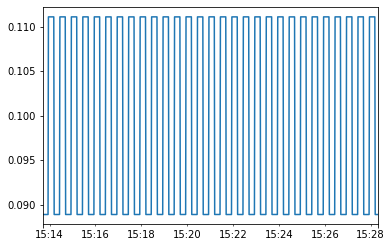

In [75]:
metric_df = metric_df.astype(float)
metric_df[QUERY][:int(len(metric_df)*3/5)].plot()
plt.show()

In [82]:
TIME_STEPS = 40

def create_sequences(values, time_steps=TIME_STEPS):
    output = []

    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])

    return np.stack(output)

def normalize(values, mean, std):
    values -= mean
    values /= std
    return values

In [110]:
metric_df_train = metric_df[:int(len(metric_df)*3/5)]
metric_df_test = metric_df[int(len(metric_df)*3/5):]

training_mean = metric_df_train.mean()
training_std = metric_df_train.std()
metric_df_train = normalize(metric_df_train, training_mean, training_std)

x_train = create_sequences(metric_df_train.values, TIME_STEPS)

In [111]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 20, 32)            256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 16)            3600      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 20, 16)            1808      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 16)            0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 40, 32)            3616      
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 40, 1)            

In [112]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=12,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
63/63 [==============================] - 1s 5ms/step - loss: 0.6677 - val_loss: 0.1677
Epoch 2/50
63/63 [==============================] - 0s 2ms/step - loss: 0.1739 - val_loss: 0.0840
Epoch 3/50
63/63 [==============================] - 0s 2ms/step - loss: 0.1069 - val_loss: 0.0537
Epoch 4/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0397

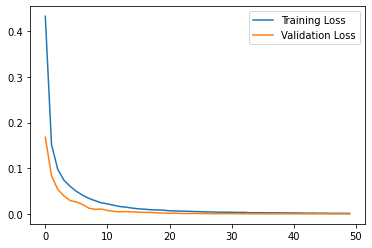

In [113]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

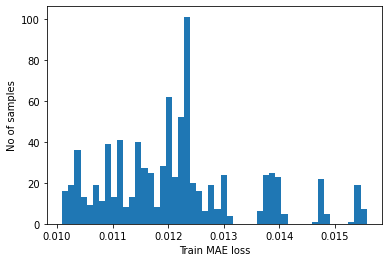

Reconstruction error threshold:  0.015567662330484233


In [114]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

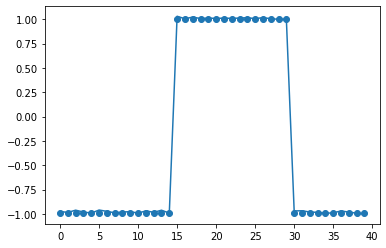

In [115]:
plt.scatter(range(len(x_train[0])), x_train[0])
plt.plot(x_train_pred[0])
plt.show()

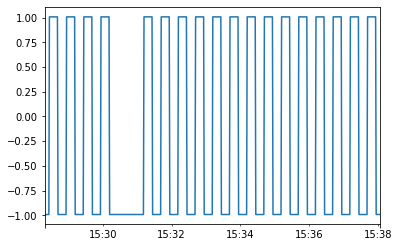

In [116]:
metric_df_test = normalize(metric_df_test, training_mean, training_std)

fig, ax = plt.subplots()
metric_df_test.plot(legend=False, ax=ax)
plt.show()

x_test = create_sequences(metric_df_test.values)

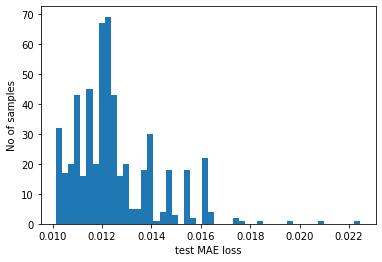

Number of anomaly samples:  35
Indices of anomaly samples:  (array([104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 140, 142]),)


In [117]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

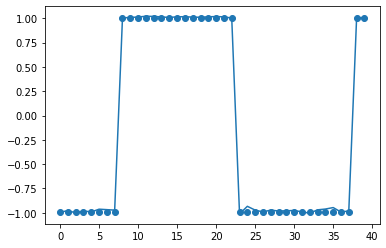

In [121]:
plt.scatter(range(len(x_test[0])), x_test[0])
plt.plot(x_test_pred[0])
plt.show()

In [126]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(metric_df_test) - TIME_STEPS + 1):
    if np.any(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

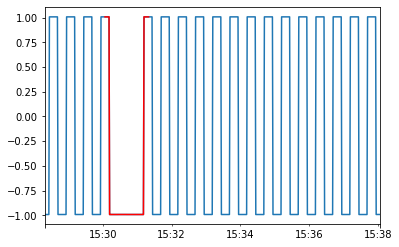

In [128]:
df_subset = metric_df_test.iloc[anomalous_data_indices]
_, ax = plt.subplots()
metric_df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()
